# Concevez une application au service de la santé publique

application : 
- Selon les directives gouvernementales, il ne faut pas manger trop gras, trop salé, trop sucré. Ces données seront exprimées en pourcentage de la composition et en pourcentage des AJR(Apports Journaliers Recommandés)
- On rajoutera le score energetique. Notre reference sera les AR = Apport de Reference pour un adulte (8400KJ) ou 3600kj pour 100g    
https://fr.wikipedia.org/wiki/Apports_journaliers_recommand%C3%A9s
- Ainsi le nutri-score pour une visualisation rapide

En scannant le produit, l'application sera à la portée de tous, claire et simple d'utilisation

## Importation des librairies et des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn import neighbors, metrics
from sklearn import preprocessing
from sklearn import model_selection
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Données

Food = pd.read_csv('openfoodfacts.org.products.csv', sep='\t')


In [2]:
Food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('Dans nos données, il y a ', Food.shape, 'ce qui correspond aux lignes, et aux colonnes')

Dans nos données, il y a  (320772, 162) ce qui correspond aux lignes, et aux colonnes


## Liste des colonnes de notre jeu de données

In [4]:
Food.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [5]:
Food[Food.duplicated(['code'])].sort_values('code')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
9892,11778,http://world-fr.openfoodfacts.org/produit/0011...,beniben,1474489149,2016-09-21T20:19:09Z,1491142385,2017-04-02T14:13:05Z,All Butter Reduced Fat Stem Ginger Cookies,NaN,225 g,...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,NaN
481,16117,http://world-fr.openfoodfacts.org/produit/0001...,usda-ndb-import,1489065258,2017-03-09T13:14:18Z,1489065258,2017-03-09T13:14:18Z,Colossal Olives With Jalapeno Peppers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,24600,http://world-fr.openfoodfacts.org/produit/0002...,tacinte,1435406581,2015-06-27T12:03:01Z,1435406592,2015-06-27T12:03:12Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560,31233,http://world-fr.openfoodfacts.org/produit/0003...,openfoodfacts-contributors,1451914937,2016-01-04T13:42:17Z,1491146137,2017-04-02T15:15:37Z,Super chicken spinach & quinoa,NaN,600 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632,58001,http://world-fr.openfoodfacts.org/produit/0005...,kiliweb,1487432837,2017-02-18T15:47:17Z,1487432838,2017-02-18T15:47:18Z,Bramley Apple Crumble,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189364,NaN,NaN,villecomtal-sur-arros-gers-france,"Courrières,France",Cora,France,en:france,France,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189379,NaN,NaN,villecomtal-sur-arros-gers-france,NaN,NaN,France,en:france,France,"_Lait_ entier (78,1%), sucre (8,5%), _lait_ éc...","Lait, lait, lait, lait, lait",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189404,NaN,NaN,villecomtal-sur-arros-gers-france,"Brétigny-sur-Orge,Marseille 5°,France","Auchan,Super U","Suisse,France","en:france,en:switzerland","France,Suisse","_lait_ entier, sucre (9,6% en moyenne), fruits...","lait, lait, lait, lait",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189406,NaN,NaN,villecomtal-sur-arros-gers-france,"Marseille 5°,France",Super U,France,en:france,France,"_lait_ entier, sucre (9,7% en moyenne), fruits...","lait, lait, lait, lait",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
doublon1 = Food[(Food.code == 58001)]
doublon1

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
155,58001,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055734,2017-03-09T10:35:34Z,1489055734,2017-03-09T10:35:34Z,Organic Salted Pistachios,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0,NaN,NaN
632,58001,http://world-fr.openfoodfacts.org/produit/0005...,kiliweb,1487432837,2017-02-18T15:47:17Z,1487432838,2017-02-18T15:47:18Z,Bramley Apple Crumble,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN


## Vérification si le code produit n'a pas de doublons et suppression si besoin

In [7]:
def double(df):
    doublons = df[df.duplicated(['code'])]
    doublons = df.drop_duplicates(subset=['code'], keep="last")
    return doublons
doublons = double(Food)

## Vérification du pourcentage de valeurs manquantes dans notre dataset

In [8]:
#pourcentage de valeurs manquantes
def pourcentage_valeurs_manquantes(data=Food):
    somme = 0
    for i in list(data.columns):
        somme += data[i].isna().sum()
    return round((somme / (data.shape[0]*data.shape[1]))*100,2)

print('Pour le jeu de données Food, nous avons :', pourcentage_valeurs_manquantes(Food) ,'% de valeurs manquantes')

Pour le jeu de données Food, nous avons : 76.22 % de valeurs manquantes


## Verification du pourcentage de valeur nul par colonnes

Au vu du nombres de valeurs nul, je créé un graphique pour une meilleur visualisation

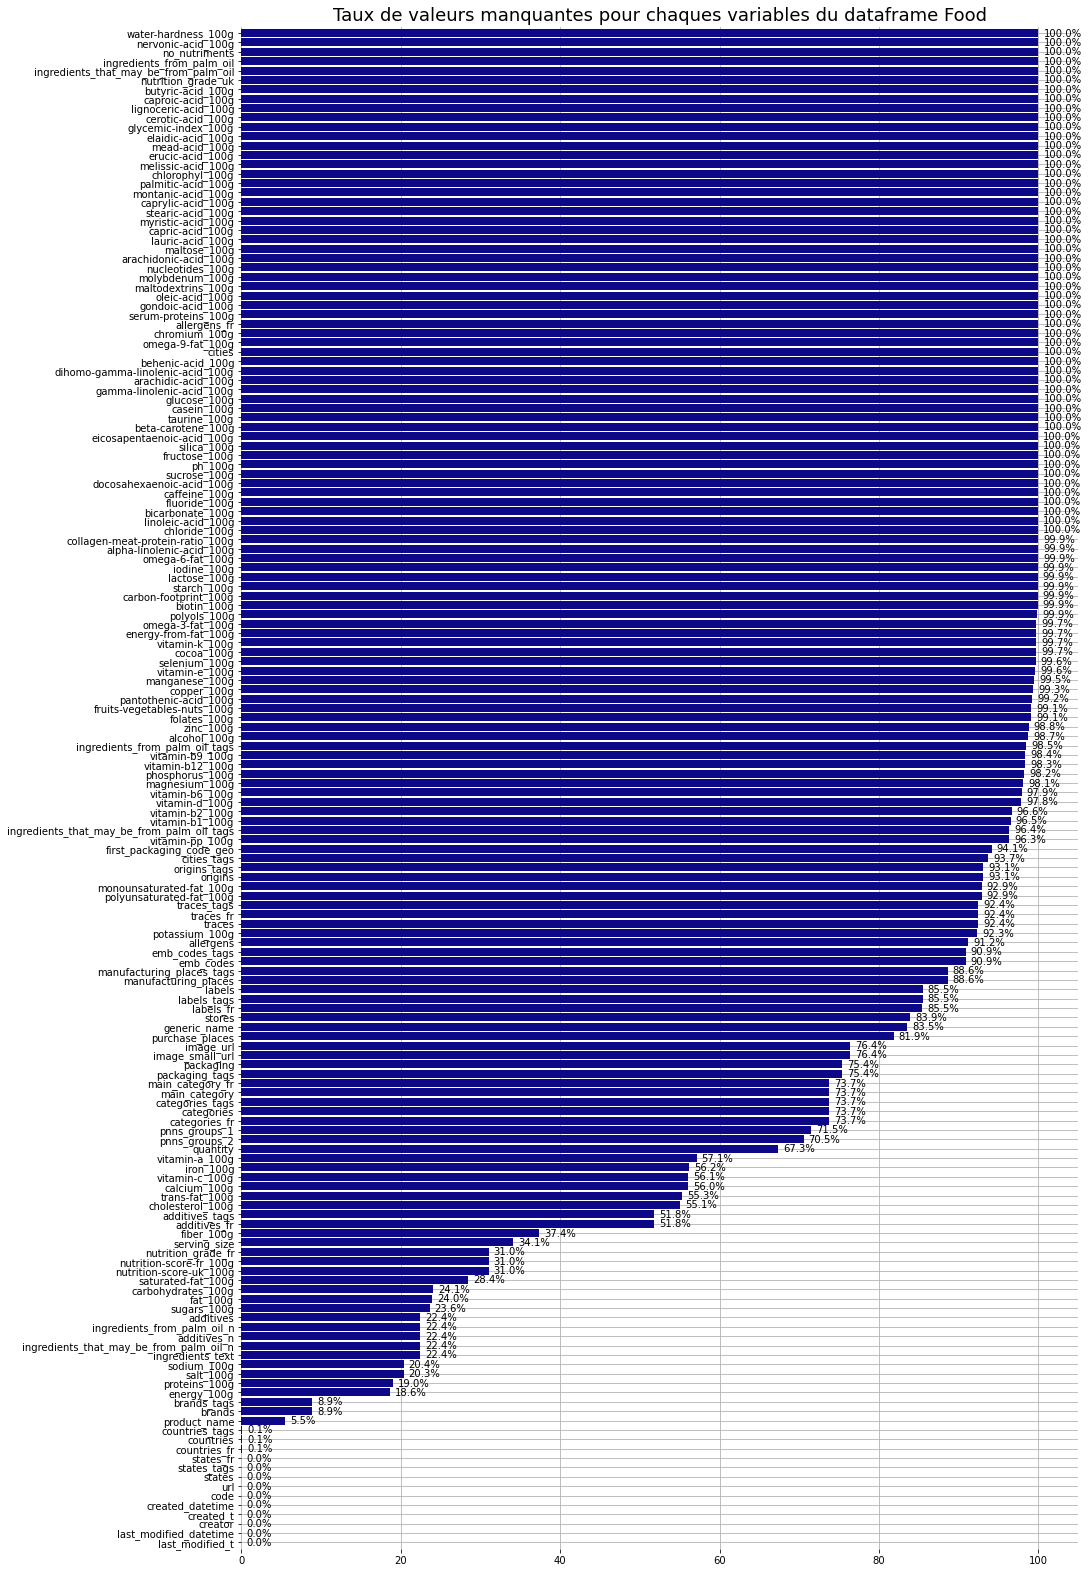

In [9]:
size = Food.shape
nan_values = Food.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

ax = nan_values.plot(kind='barh', 
                     figsize=(15, 28), 
                     colormap= 'plasma',
                     zorder=2,
                     width=0.85)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

rects = ax.patches

# Pour chaque barre, un label indiqué
for rect in rects:
    # placement du label en X et Y.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # espace entre la barre et le label
    space = 5
    # Positionnement pour les valeurs positives
    ha = 'left'

    # Si la valeur est négative, place la valeur à gauche de la barre
    if x_value < 0:
        # intervalle pour placer le label
        space *= -1
        # positonnement du label horizontal et à droite
        ha = 'right'

    # La valeur du label X aura un chiffre derrière la virgule, et ajoute du signe %
    label = "{:.1f}".format(x_value) + str('%')

    # annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Placer label à la fin bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
    
ax.set_title("Taux de valeurs manquantes pour chaques variables du dataframe Food", fontsize=18)
       
plt.grid()
plt.savefig("image.png")

Afin d'avoir sufisamment de données et de visibilité, je garde que les colonnes où il y a au moins 50 % de données.

In [10]:
nan_values = nan_values[nan_values < 50]
nan_values

last_modified_t                             0.000000
last_modified_datetime                      0.000000
creator                                     0.000623
created_t                                   0.000935
created_datetime                            0.002806
code                                        0.007170
url                                         0.007170
states                                      0.014340
states_tags                                 0.014340
states_fr                                   0.014340
countries_fr                                0.087289
countries                                   0.087289
countries_tags                              0.087289
product_name                                5.537266
brands                                      8.857382
brands_tags                                 8.859876
energy_100g                                18.598568
proteins_100g                              18.969860
salt_100g                                  20.

Après une analyse de nos colonnes restantes, nous confirmons que notre choix d'application est approprié sur ce dataset.
C'est pourquoi je selectionne que ce dont j'ai besoin pour l'application. Je decide aussi de garder la colonne 'pnns_group_1' correspondant au catégorie de produits.

In [11]:
Food.pnns_groups_1.unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

- Nous pouvons deja remarquer des similitudes entre certaines colonnes, comme : 'Fruits and vegetables' et 'fruits-and-vegetables'. Je decide donc de les fusionner pour qu'elle ai la même entité.
- Concernant les valeurs NaN, je préfère garder ces lignes est faire en sorte qu'elles soient calssé dans 'unknown'.

In [12]:
def categ(df):
    df['pnns_groups_1'] = df['pnns_groups_1'].replace(['cereals-and-potatoes'], 'Cereals and potatoes')
    df['pnns_groups_1'] = df['pnns_groups_1'].replace(['fruits-and-vegetables'], 'Fruits and vegetables')
    df['pnns_groups_1'] = df['pnns_groups_1'].replace(['sugary-snacks'], 'Sugary snacks')
    df['pnns_groups_1'] = df['pnns_groups_1'].fillna('unknown')
    categorie = df
    return categorie
categorie = categ(doublons)

## choix colonnes

In [13]:
def colonnes(df):
    features = df[['code', 
    'countries_fr', 
    'product_name',
    'pnns_groups_1',
    'energy_100g',
    'salt_100g', 
    'sugars_100g', 
    'fat_100g', 
    'saturated-fat_100g', 
    'nutrition-score-fr_100g',
    'nutrition_grade_fr']]
    return features
features = colonnes(categorie)


## Produits vendus en France

In [14]:
def france(df):
        df['countries_fr'] = df['countries_fr'].str.upper()
        df = df[df['countries_fr'].isna() == False]
        country = df[df['countries_fr'].str.contains('FR')]
        return country
country = france(features)

## Detection des valeurs abérrantes

Les valeurs renseignées sont pour 100g de produits, donc logiquement, les apports nutritionnels ne peuvent pas dépasser 100g. De même qu'il ne peut pas avoir de valeurs négatives.
Concernant l'energie exprimé en KJ, elle ne peut pas dépasser 3600 pour 100g


In [15]:
def valeurs_aberrantes(df):
    valeurs = df[(df.energy_100g > 3700) | 
                (df.salt_100g < 0) |  
                (df.salt_100g > 100) |
                (df.sugars_100g < 0) |
                (df.sugars_100g > 100) |
                (df.fat_100g < 0) |
                (df.fat_100g > 100) |
                (df['saturated-fat_100g'] < 0) |
                (df['saturated-fat_100g'] > 100)] 
    return valeurs.code
valeurs = valeurs_aberrantes(country)
outliers = country[~country.code.isin(valeurs)]


## detection des outliers

In [16]:
# Calcul de l'ecart interquartile
q1 = Food.energy_100g.quantile(0.25)
q3 = Food.energy_100g.quantile(0.75)
ecart = q3-q1
print(round((ecart),2), 'ecart interquartile')
# trouver les limites intérieures, valeurs aberrantes mineurs
mineur = ecart*1.5
limite_inf = round(q1- mineur,2)
limite_sup = round(q3+ mineur,2)
print('les valeurs en dessous de', limite_inf,' sont jugé valeur abérrante mineur')
print('les valeurs au dessus de', limite_sup,' sont jugé valeur abérrante mineur')
# trouver les limites supérieures, valeurs aberrantes majeurs
majeur = ecart*3
sup_majeur = round(q3+ majeur,2)
print('les valeurs au dessus de', sup_majeur,' sont jugé valeur abérrante majeur')

1297.0 ecart interquartile
les valeurs en dessous de -1568.5  sont jugé valeur abérrante mineur
les valeurs au dessus de 3619.5  sont jugé valeur abérrante mineur
les valeurs au dessus de 5565.0  sont jugé valeur abérrante majeur


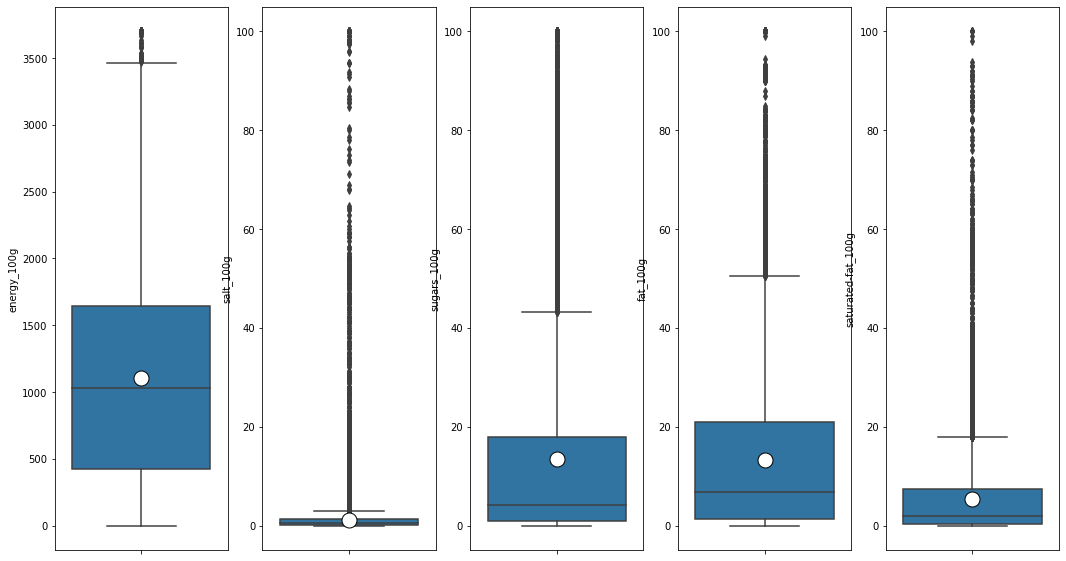

In [17]:
fig, ax = plt.subplots(1,5, figsize=(18,10))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=outliers, y='energy_100g', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=outliers, y='salt_100g', showmeans=True, meanprops=meanprops, ax=ax[1])
sns.boxplot(data=outliers, y='sugars_100g', showmeans=True, meanprops=meanprops, ax=ax[2])
sns.boxplot(data=outliers, y='fat_100g', showmeans=True, meanprops=meanprops, ax=ax[3])
sns.boxplot(data=outliers, y='saturated-fat_100g', showmeans=True, meanprops=meanprops, ax=ax[4])

plt.show()

## Regard sur les valeurs manquantes de notre DF

In [18]:
column_with_nan = outliers.columns[outliers.isnull().any()]
Food.shape
# boucle 
for column in column_with_nan:
    print(column, outliers[column].isnull().sum())

code 1
product_name 7218
energy_100g 33910
salt_100g 35924
sugars_100g 35984
fat_100g 50679
saturated-fat_100g 36130
nutrition-score-fr_100g 37084
nutrition_grade_fr 37084


Nous pouvons remarquer qu'il y a 7218 produits qui ne sont pas nommés.

## Suppression des produits et des codes qui ne sont pas nommés 

In [19]:
def nom(df):    
    df = df[df["product_name"].isna() == False]
    product = df[df['code'].isna() == False]
    return product
product = nom(outliers)

In [20]:
column_with_nan = product.columns[product.isnull().any()]
Food.shape
# boucle 
for column in column_with_nan:
    print(column, product[column].isnull().sum())

energy_100g 27061
salt_100g 29063
sugars_100g 29123
fat_100g 43811
saturated-fat_100g 29261
nutrition-score-fr_100g 30206
nutrition_grade_fr 30206


In [21]:
apport_nutrition = []
for i in product :
    if "_100g" in i :
        apport_nutrition.append(i)  # append() ajoute les éléments dans une liste mais conserve la forme d'itérable
print('Le nombre de lignes où il n\'y a aucunes informations sur les nutriments est de :{}'.format(product[apport_nutrition].isnull().all(axis=1).sum()))

Le nombre de lignes où il n'y a aucunes informations sur les nutriments est de :26360


In [22]:
def ligne_nan (df):
    apport_nutrition = []
    for i in product :
        if "_100g" in i :
            apport_nutrition.append(i) 
    Apport_Null = df[df[apport_nutrition].notnull().any(axis=1)]
    return Apport_Null
Apport_Null = ligne_nan(product)
print('Après cette opération, il reste', Apport_Null.shape, 'lignes et colonnes')

Après cette opération, il reste (64706, 11) lignes et colonnes


## Recherche de corrélation entre variables

In [23]:
Apport_Null['nutrition_grade_fr'] = Apport_Null['nutrition_grade_fr'].map({'a':1, 'b':2, 'c':3, 'd':4, 'e':5})

Apport_Null.corr()

,energy_100g,salt_100g,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
energy_100g,1.000000,-0.024295,0.335910,0.781548,0.574679,0.625764,0.520994
salt_100g,-0.024295,1.000000,-0.088897,0.011316,0.009665,0.121581,0.104636
sugars_100g,0.335910,-0.088897,1.000000,0.005850,0.085261,0.455494,0.404976
fat_100g,0.781548,0.011316,0.005850,1.000000,0.742621,0.581306,0.507220
saturated-fat_100g,0.574679,0.009665,0.085261,0.742621,1.000000,0.609269,0.528241
nutrition-score-fr_100g,0.625764,0.121581,0.455494,0.581306,0.609269,1.000000,0.945697
nutrition_grade_fr,0.520994,0.104636,0.404976,0.507220,0.528241,0.945697,1.000000


In [24]:
Apport_Null['nutrition_grade_fr'] = Apport_Null['nutrition_grade_fr'].map({1:'a', 2:'b', 3:'c', 4:'d', 5:'e'})

##  Imputation

In [25]:
def Food_All(df):
    df['nutrition_grade_fr'] = df['nutrition_grade_fr'].map({'a':1, 'b':2, 'c':3, 'd':4, 'e':5})
    Food_nutri = df[['nutrition-score-fr_100g', 'nutrition_grade_fr']]
    imp_median = IterativeImputer(initial_strategy= 'median', max_iter=10, random_state=0, imputation_order='ascending')
    Z = imp_median.fit_transform(Food_nutri)

    Food_nutri = pd.DataFrame(Z, index = df.code, columns = Food_nutri.columns).astype(int)
    Food_nutri['nutrition_grade_fr'] = Food_nutri['nutrition_grade_fr'].map({1:'a', 2:'b', 3:'c', 4:'d', 5:'e'})

    Food_all = df[['energy_100g', 'fat_100g', 'sugars_100g', 'salt_100g', 'saturated-fat_100g']]
    imputer = KNNImputer(n_neighbors = 10, weights='distance')
    X = imputer.fit_transform(Food_all)

    Food_all = pd.DataFrame(X, index = df.code, columns = Food_all.columns)
    
    features = df.drop(columns={'countries_fr', 'energy_100g', 'salt_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g', 'nutrition_grade_fr'})
    result_value = pd.merge(Food_nutri, Food_all, on='code', how='inner')
    result = pd.merge(features, result_value, on='code', how='inner')
    display(result)
    return result.reset_index()
result = Food_All(Apport_Null)

,code,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,salt_100g,saturated-fat_100g
0,36252,Lion Peanut x2,unknown,22,e,1883.0,20.000000,57.50,0.09652,12.500
1,39529,Pack de 2 Twix,unknown,8,c,1481.0,4.170000,22.13,0.12150,1.083
2,10187319,Mini Confettis,unknown,14,d,1753.0,2.534546,87.70,0.01000,0.800
3,10207260,Praliné Amande Et Noisette,unknown,14,d,2406.0,36.516162,50.30,0.00300,2.900
4,40608754,"Pepsi, Nouveau goût !",Beverages,13,e,177.0,0.000000,10.40,0.02540,0.000
...,...,...,...,...,...,...,...,...,...,...
64701,9782211109758,Verrine Cheescake Myrtille,unknown,16,d,1084.0,6.132825,10.50,0.29000,12.000
64702,9782401029101,Fiche Brevet,unknown,0,b,4.0,0.000000,1.00,10.00000,1.000
64703,9847548283004,Tartines craquantes bio au sarrasin,Cereals and potatoes,-4,a,1643.0,2.800000,2.60,0.68000,0.600
64704,9900000000233,Amandes,unknown,0,b,2406.0,37.000000,3.89,0.10000,3.730


## Vérification de nos données imputées

Je garde que les valeurs numériques de notre dataset

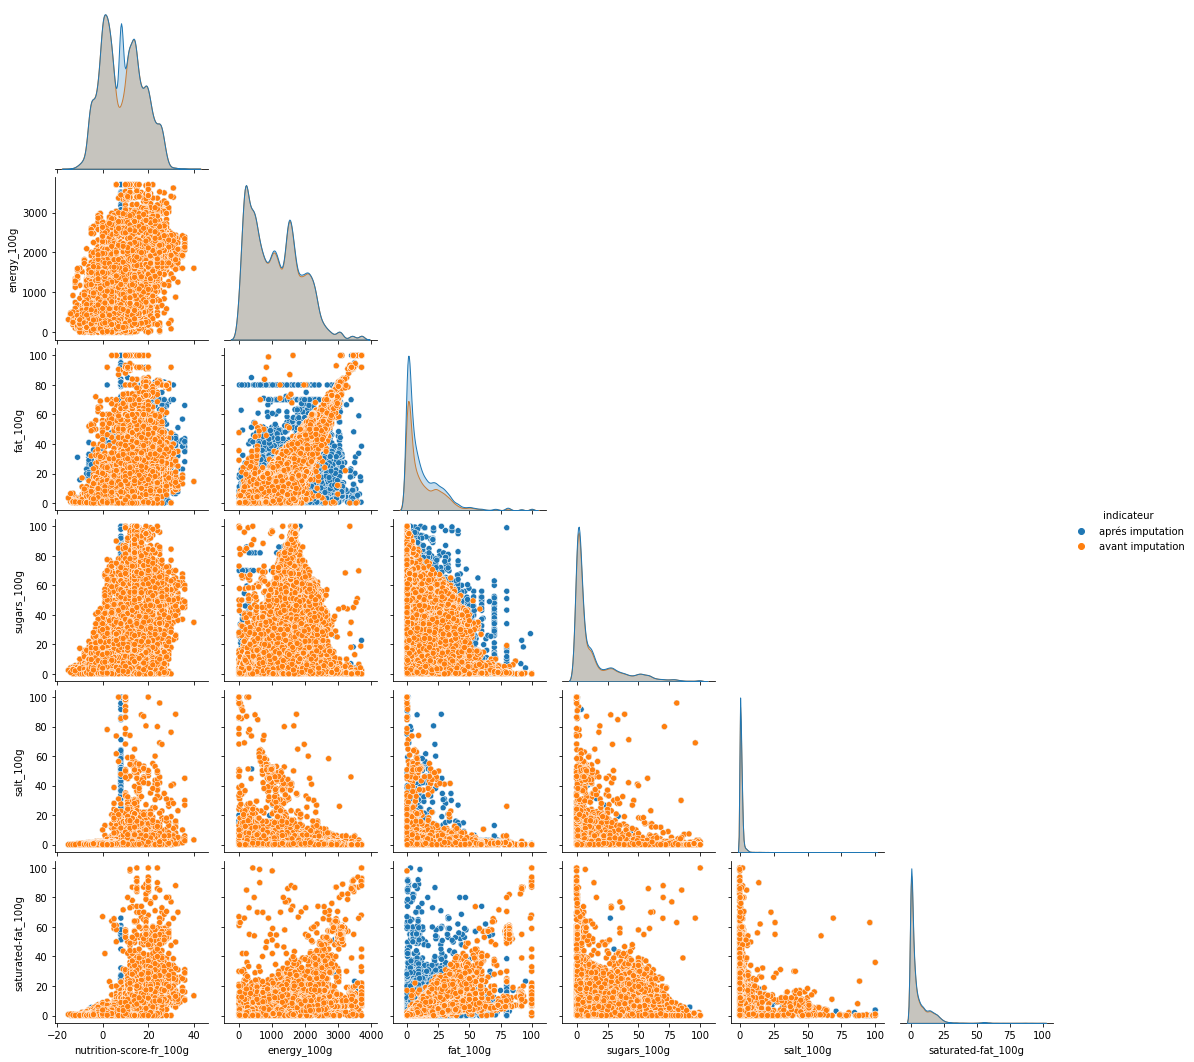

In [26]:

result['indicateur'] = 'aprés imputation'
Apport_Null['indicateur'] = 'avant imputation'
result = result.drop('index', axis = 1)
temp = pd.concat([result, Apport_Null])

sns.pairplot(temp, hue='indicateur', corner=True)

## Fonction de nettoyage

In [27]:
def nettoyage():
    Food = pd.read_csv(str(input('Comment s\'appelle votre fichier ?(avec l\'extention)')), sep='\t')
    doublons = double(Food)
    categorie = categ(doublons)
    features = colonnes(categorie)
    country = france(features)
    valeurs = valeurs_aberrantes(country)
    outliers = country[~country.code.isin(valeurs)]
    product = nom(outliers)
    Apport_Null = ligne_nan(product)
    result = Food_All(Apport_Null)
    result.to_csv('result_clean', index=False)
    return result

result_value = nettoyage()

Comment s'appelle votre fichier ?(avec l'extention)openfoodfacts.org.products.csv


,code,product_name,pnns_groups_1,nutrition-score-fr_100g,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,salt_100g,saturated-fat_100g
0,36252,Lion Peanut x2,unknown,22,e,1883.0,20.000000,57.50,0.09652,12.500
1,39529,Pack de 2 Twix,unknown,8,c,1481.0,4.170000,22.13,0.12150,1.083
2,10187319,Mini Confettis,unknown,14,d,1753.0,2.534546,87.70,0.01000,0.800
3,10207260,Praliné Amande Et Noisette,unknown,14,d,2406.0,36.516162,50.30,0.00300,2.900
4,40608754,"Pepsi, Nouveau goût !",Beverages,13,e,177.0,0.000000,10.40,0.02540,0.000
...,...,...,...,...,...,...,...,...,...,...
64701,9782211109758,Verrine Cheescake Myrtille,unknown,16,d,1084.0,6.132825,10.50,0.29000,12.000
64702,9782401029101,Fiche Brevet,unknown,0,b,4.0,0.000000,1.00,10.00000,1.000
64703,9847548283004,Tartines craquantes bio au sarrasin,Cereals and potatoes,-4,a,1643.0,2.800000,2.60,0.68000,0.600
64704,9900000000233,Amandes,unknown,0,b,2406.0,37.000000,3.89,0.10000,3.730
